In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import make_grid
from visualise import visualise_v_quiver

from configs import N_SIDE

In [3]:
# Import all simulation functions
from simulate import (
    simulate_detailed_convergence,
    simulate_detailed_deflection,
    simulate_detailed_curve,
    simulate_detailed_ridges,
    simulate_detailed_branching,
    simulate_detailed_edge
)

# Define simulations as a dictionary with names as keys to function objects
# Order matters
simulations = {
    "curve": simulate_detailed_curve,
    "deflection": simulate_detailed_deflection,
    "ridges": simulate_detailed_ridges,
    "branching": simulate_detailed_branching,
    "edge": simulate_detailed_edge,
}

In [14]:
#############
### TRAIN ###
#############

x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Storage dictionaries
y_train_dict = {}

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate training observations with sim_func
    y_train = sim_func(x_train)
    # Store training data in dictionary under sim_name
    y_train_dict[sim_name] = y_train 

############
### TEST ###
############

# Make x_grid
_, x_test = make_grid(n_side = N_SIDE)

# Storage dictionaries
y_test_dict = {}

# Make y_test_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate test observations
    y_test = sim_func(x_test)
    y_test_dict[sim_name] = y_test  # Store test outputs

    print(f"Simulated {sim_name} - mean of u and v: {y_test.mean(dim = 0)}")
    print(f"Simulated {sim_name} - var of u and v: {y_test.var(dim = 0)}")
    print(f"Simulated {sim_name} - mean magnitude: {y_test.norm(dim = -1).mean():.2f}")

Simulated curve - mean of u and v: tensor([1.4301, 0.5677])
Simulated curve - var of u and v: tensor([0.2932, 0.1171])
Simulated curve - mean magnitude: 1.57
Simulated deflection - mean of u and v: tensor([1.3603, 0.1409])
Simulated deflection - var of u and v: tensor([0.1858, 0.3876])
Simulated deflection - mean magnitude: 1.47
Simulated ridges - mean of u and v: tensor([ 0.3839, -1.4049])
Simulated ridges - var of u and v: tensor([0.0796, 1.1888])
Simulated ridges - mean magnitude: 1.48
Simulated branching - mean of u and v: tensor([ 0.2863, -0.6087])
Simulated branching - var of u and v: tensor([0.0551, 0.1888])
Simulated branching - mean magnitude: 0.74
Simulated edge - mean of u and v: tensor([0.7855, 0.1349])
Simulated edge - var of u and v: tensor([0.3066, 0.0322])
Simulated edge - mean magnitude: 0.81


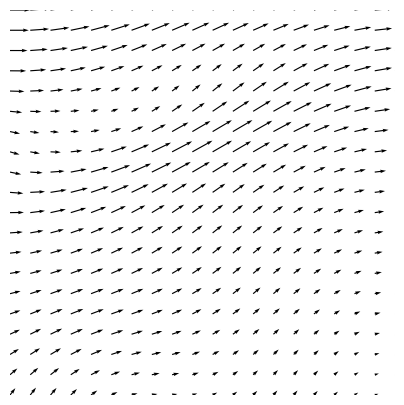

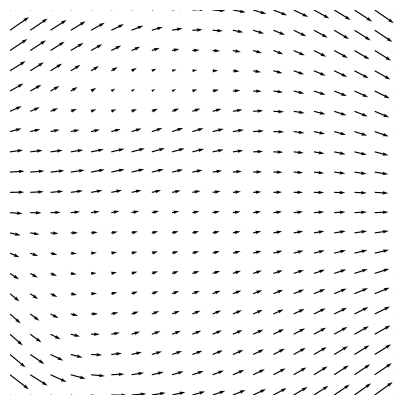

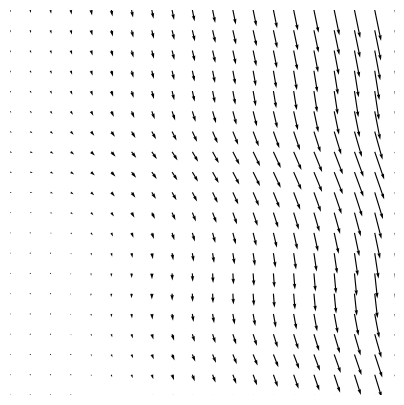

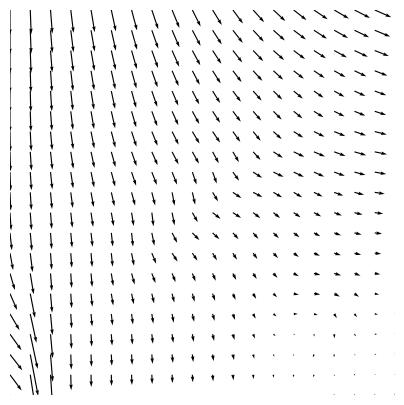

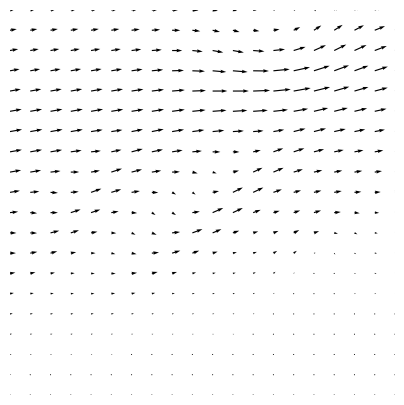

In [15]:
standard_quiver_scale = 47
branching_quiver_scale = 22

x_test = x_test.detach()

for (sim_name, y_train) in y_train_dict.items():

    y_test = y_test_dict[sim_name]

    fig, ax = plt.subplots(1, 1, figsize = (5, 5))

    quiver_scale = standard_quiver_scale
    if sim_name == "branching":
        quiver_scale = branching_quiver_scale
    
    # Plot ground truth test data in black
    ax.quiver(x_test[:, 0], x_test[:, 1], y_test[:, 0], y_test[:, 1], scale = quiver_scale, color = "black")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_aspect("equal")

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.show()
    plt.close()

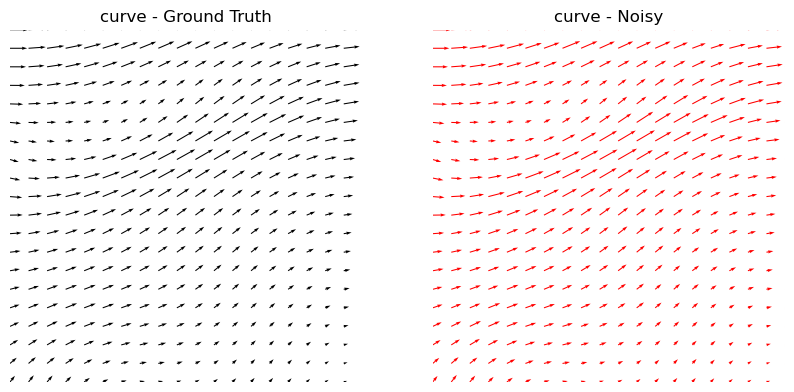

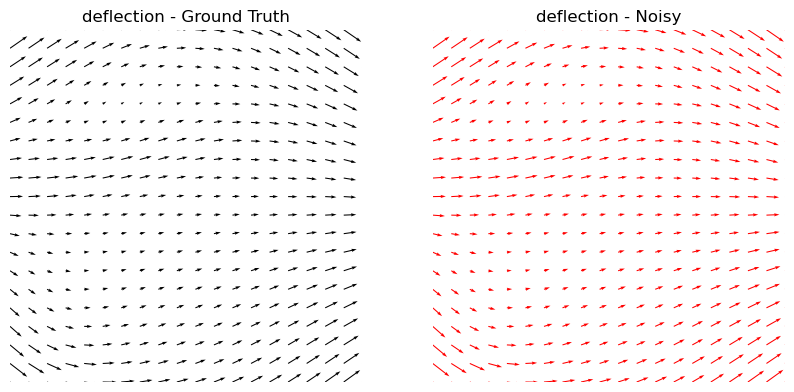

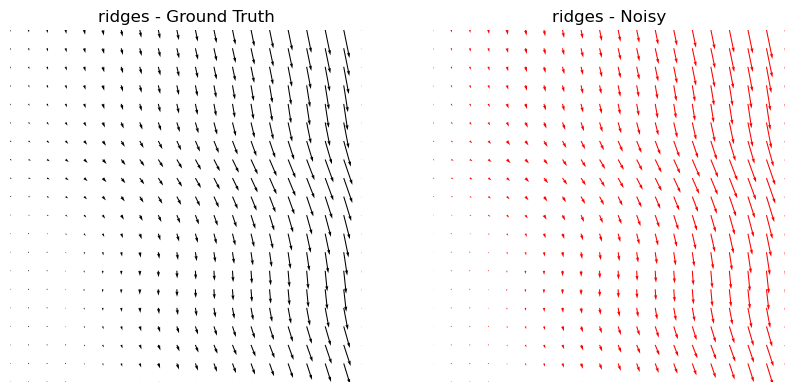

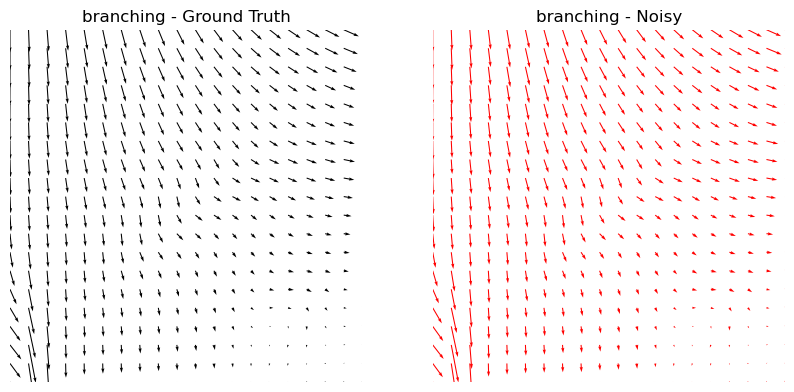

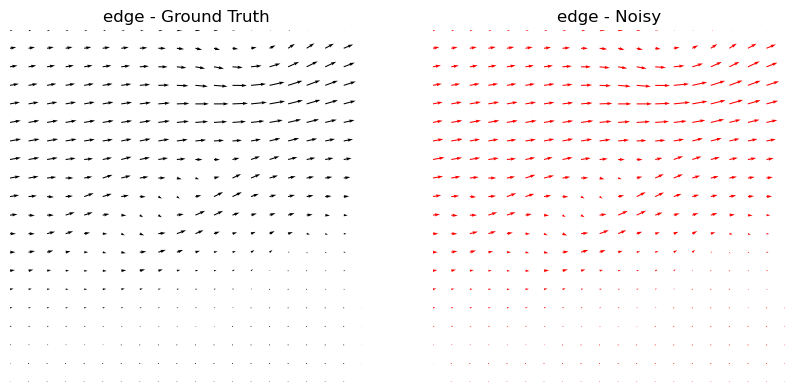

In [32]:
import numpy as np

# 5% noise applied to the magnitude
noise_factor = 0.04

x_test = x_test.detach()

for (sim_name, y_train) in y_train_dict.items():
    y_test = y_test_dict[sim_name]

    fig, (ax_gt, ax_noisy) = plt.subplots(1, 2, figsize=(10, 5))  # 2 subplots for GT and noisy

    quiver_scale = standard_quiver_scale
    if sim_name == "branching":
        quiver_scale = branching_quiver_scale

    # Plot ground truth test data (GT)
    ax_gt.quiver(x_test[:, 0], x_test[:, 1], y_test[:, 0], y_test[:, 1], scale=quiver_scale, color="black")
    ax_gt.set_title(f"{sim_name} - Ground Truth")

    # Apply 5% noise to the magnitude of each vector
    magnitudes = torch.norm(y_test, dim=1)  # Magnitudes of u and v
    noisy_magnitudes = magnitudes * (1 + noise_factor * torch.randn_like(magnitudes))  # Add noise
    noisy_vectors = torch.stack([noisy_magnitudes * (y_test[:, 0] / magnitudes), 
                                 noisy_magnitudes * (y_test[:, 1] / magnitudes)], dim=1)

    # Plot noisy data
    ax_noisy.quiver(x_test[:, 0], x_test[:, 1], noisy_vectors[:, 0], noisy_vectors[:, 1], scale=quiver_scale, color="red")
    ax_noisy.set_title(f"{sim_name} - Noisy")

    # Set limits and remove axis labels
    for ax in [ax_gt, ax_noisy]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")

        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.show()
    plt.close()


In [36]:
torch.set_printoptions(precision = 3, sci_mode = False)
(noisy_vectors - y_test).abs().mean()

tensor(0.019)

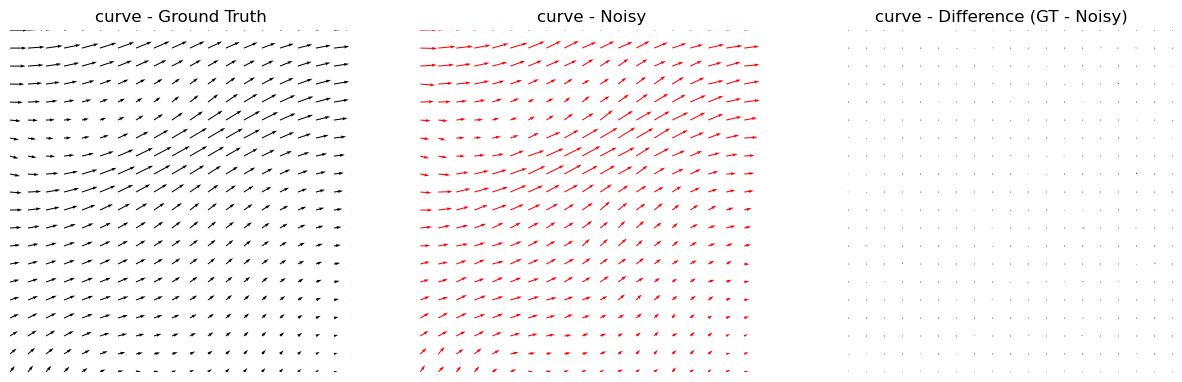

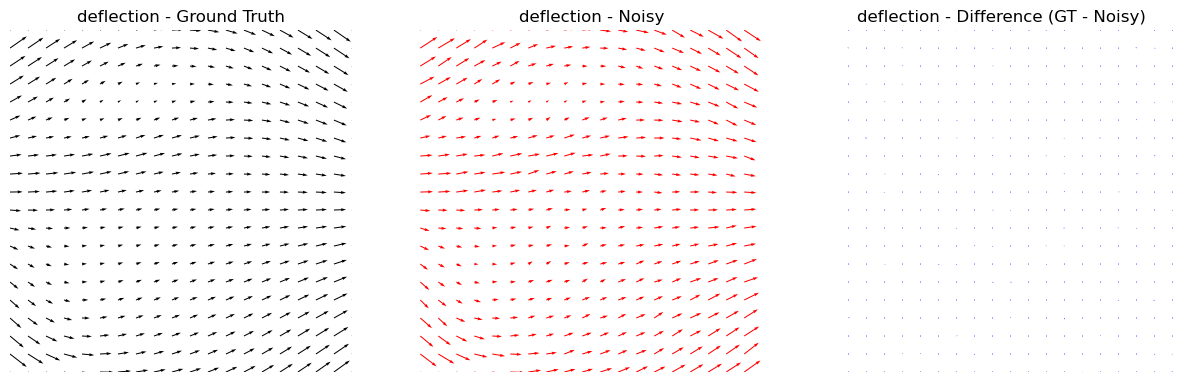

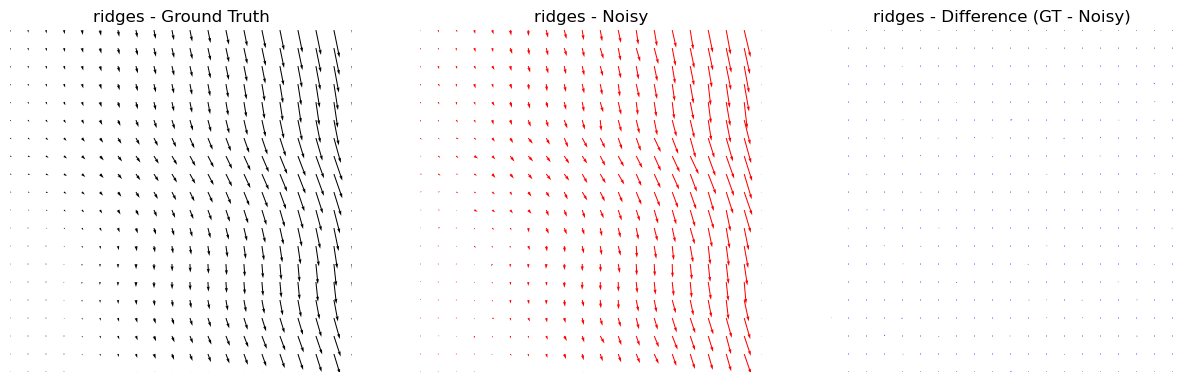

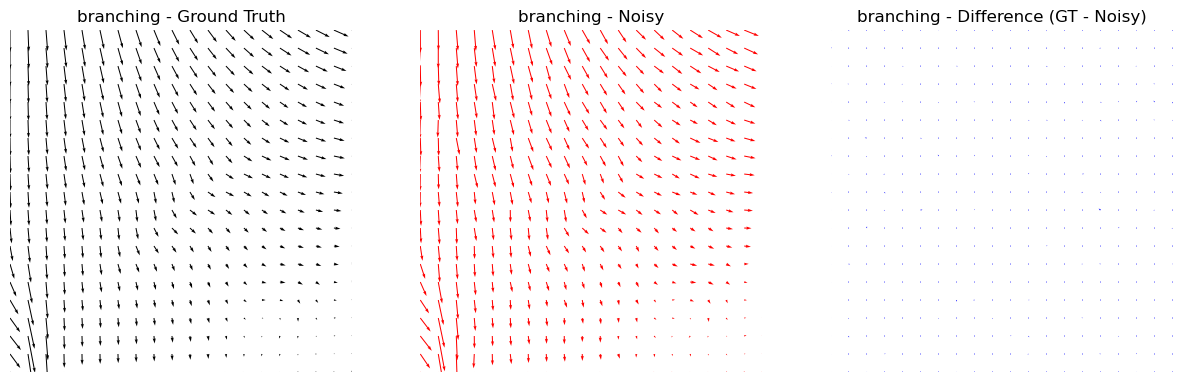

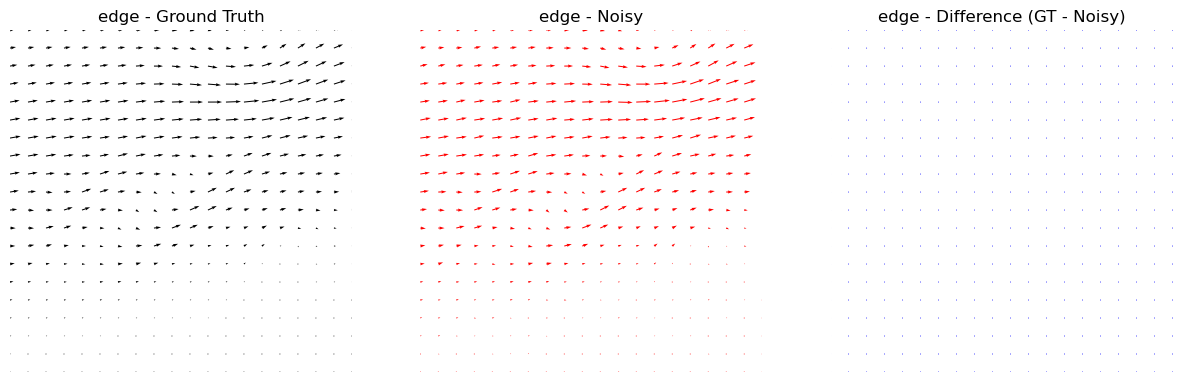

In [76]:
import numpy as np

# 5% noise applied to the magnitude
# standard deviation
noise_factor = 0.05

x_test = x_test.detach()

for (sim_name, y_train) in y_train_dict.items():
    y_test = y_test_dict[sim_name]

    fig, (ax_gt, ax_noisy, ax_diff) = plt.subplots(1, 3, figsize=(15, 5))  # 3 subplots: GT, noisy, difference

    quiver_scale = standard_quiver_scale
    if sim_name == "branching":
        quiver_scale = branching_quiver_scale

    # Plot ground truth test data (GT)
    ax_gt.quiver(x_test[:, 0], x_test[:, 1], y_test[:, 0], y_test[:, 1], scale=quiver_scale, color="black")
    ax_gt.set_title(f"{sim_name} - Ground Truth")

    # Apply 5% noise to the magnitude of each vector
    magnitude = torch.norm(y_test, dim = -1).mean() # mean magnitude
    noise = noise_factor * magnitude # noise

    additive_noise = torch.randn_like(y_test) * noise # additive noise
    noisy_vectors = y_test + additive_noise

    # Plot noisy data
    ax_noisy.quiver(x_test[:, 0], x_test[:, 1], noisy_vectors[:, 0], noisy_vectors[:, 1], scale=quiver_scale, color="red")
    ax_noisy.set_title(f"{sim_name} - Noisy")

    # Calculate differences (ground truth - noisy)
    diff_u = y_test[:, 0] - noisy_vectors[:, 0]
    diff_v = y_test[:, 1] - noisy_vectors[:, 1]

    # Plot the difference in vectors (GT - noisy)
    ax_diff.quiver(x_test[:, 0], x_test[:, 1], diff_u, diff_v, scale=quiver_scale, color="blue")
    ax_diff.set_title(f"{sim_name} - Difference (GT - Noisy)")

    # Set limits and remove axis labels for all plots
    for ax in [ax_gt, ax_noisy, ax_diff]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")

        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.show()
    plt.close()

In [75]:
print("Mean magnitude for edge:", torch.norm(y_test, dim = -1).mean().item())
print("Noise for edge:", noise.item())

# Check: std of the additive noise is as expected
print("Std of additive noise", additive_noise.std())
print("Mean of the additive noise:", additive_noise.mean())

Mean magnitude for edge: 0.8083325028419495
Noise for edge: 0.04041662439703941
Std of additive noise tensor(0.040)
Mean of the additive noise: tensor(0.000)


In [48]:
(y_test - noisy_vectors).abs().mean(dim = 0)

tensor([0.066, 0.014])